# Lab 1: Adversarial Robustness Toolbox (ART) Framework

## Objectives
- Set up and configure ART
- Implement multiple attack types (FGSM, PGD, C&W)
- Evaluate defense mechanisms
- Measure robustness metrics

## Prerequisites
- PyTorch installed
- Basic understanding of adversarial attacks
- Familiarity with image classification

## Setup and Installation

In [11]:
# Install ART if needed
try:
    import art
except ImportError:
    print("Installing Adversarial Robustness Toolbox...")
    import subprocess
    subprocess.check_call(['pip', 'install', '-q', 'adversarial-robustness-toolbox==1.17.0'])
    import art

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from art.estimators.classification import PyTorchClassifier
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent, CarliniLInfMethod
# Note: Defense modules have been reorganized in newer ART versions
try:
    from art.defenses.preprocessor import JpegCompression
except ImportError:
    # Fallback for newer ART versions
    JpegCompression = None

# Detect device
if torch.cuda.is_available():
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(f'Using device: {device}')
print('ART loaded successfully!')

Using device: mps
ART loaded successfully!


## Part 1: Load Dataset and Model

In [12]:
# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Download and load test data
testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

# Use a subset for faster testing
test_loader = torch.utils.data.DataLoader(
    testset,
    batch_size=100,
    shuffle=False
)

# Get a batch of test images
x_test, y_test = next(iter(test_loader))
x_test = x_test.numpy()
y_test = y_test.numpy()

print(f'Test data shape: {x_test.shape}')
print(f'Test labels shape: {y_test.shape}')

# CIFAR-10 classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Test data shape: (100, 3, 32, 32)
Test labels shape: (100,)


In [13]:
# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Create model
model = SimpleCNN().to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print('Model created successfully!')
print(f'Total parameters: {sum(p.numel() for p in model.parameters())}')

Model created successfully!
Total parameters: 545098


## Part 2: Wrap Model with ART

In [14]:
# Wrap the PyTorch model with ART
classifier = PyTorchClassifier(
    model=model,
    loss=criterion,
    optimizer=optimizer,
    input_shape=(3, 32, 32),
    nb_classes=10,
    clip_values=(0, 1),
    device_type='gpu' if device.type in ['cuda', 'mps'] else 'cpu'
)

# Evaluate baseline accuracy
predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == y_test) / len(y_test)

print(f'Baseline accuracy: {accuracy:.2%}')
print('Note: Low accuracy is expected for untrained model')

Baseline accuracy: 16.00%
Note: Low accuracy is expected for untrained model


## Part 3: Fast Gradient Sign Method (FGSM) Attack

In [15]:
# Create FGSM attack
fgsm = FastGradientMethod(
    estimator=classifier,
    eps=0.1,  # Perturbation budget
    targeted=False
)

# Generate adversarial examples
print('Generating FGSM adversarial examples...')
x_test_adv_fgsm = fgsm.generate(x=x_test)

# Evaluate on adversarial examples
predictions_adv = classifier.predict(x_test_adv_fgsm)
accuracy_adv = np.sum(np.argmax(predictions_adv, axis=1) == y_test) / len(y_test)

print(f'\nFGSM Attack Results:')
print(f'  Baseline accuracy: {accuracy:.2%}')
print(f'  Adversarial accuracy: {accuracy_adv:.2%}')
print(f'  Accuracy drop: {(accuracy - accuracy_adv):.2%}')

# Calculate perturbation statistics
perturbation = np.abs(x_test_adv_fgsm - x_test)
print(f'\nPerturbation Statistics:')
print(f'  Mean: {perturbation.mean():.4f}')
print(f'  Max: {perturbation.max():.4f}')
print(f'  L2 norm: {np.linalg.norm(perturbation.flatten()):.4f}')

Generating FGSM adversarial examples...

FGSM Attack Results:
  Baseline accuracy: 16.00%
  Adversarial accuracy: 6.00%
  Accuracy drop: 10.00%

Perturbation Statistics:
  Mean: 0.0965
  Max: 0.1000
  L2 norm: 54.1547


## Part 4: Projected Gradient Descent (PGD) Attack

In [16]:
# Create PGD attack (stronger than FGSM)
pgd = ProjectedGradientDescent(
    estimator=classifier,
    eps=0.1,
    eps_step=0.01,
    max_iter=20,
    targeted=False
)

# Generate adversarial examples
print('Generating PGD adversarial examples...')
x_test_adv_pgd = pgd.generate(x=x_test)

# Evaluate on adversarial examples
predictions_adv_pgd = classifier.predict(x_test_adv_pgd)
accuracy_adv_pgd = np.sum(np.argmax(predictions_adv_pgd, axis=1) == y_test) / len(y_test)

print(f'\nPGD Attack Results:')
print(f'  Baseline accuracy: {accuracy:.2%}')
print(f'  Adversarial accuracy: {accuracy_adv_pgd:.2%}')
print(f'  Accuracy drop: {(accuracy - accuracy_adv_pgd):.2%}')

# Compare with FGSM
print(f'\nComparison:')
print(f'  FGSM accuracy drop: {(accuracy - accuracy_adv):.2%}')
print(f'  PGD accuracy drop: {(accuracy - accuracy_adv_pgd):.2%}')
print(f'  PGD is stronger: {accuracy_adv_pgd < accuracy_adv}')

Generating PGD adversarial examples...


PGD - Batches:   0%|          | 0/4 [00:00<?, ?it/s]


PGD Attack Results:
  Baseline accuracy: 16.00%
  Adversarial accuracy: 8.00%
  Accuracy drop: 8.00%

Comparison:
  FGSM accuracy drop: 10.00%
  PGD accuracy drop: 8.00%
  PGD is stronger: False


## Part 5: Visualize Adversarial Examples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].


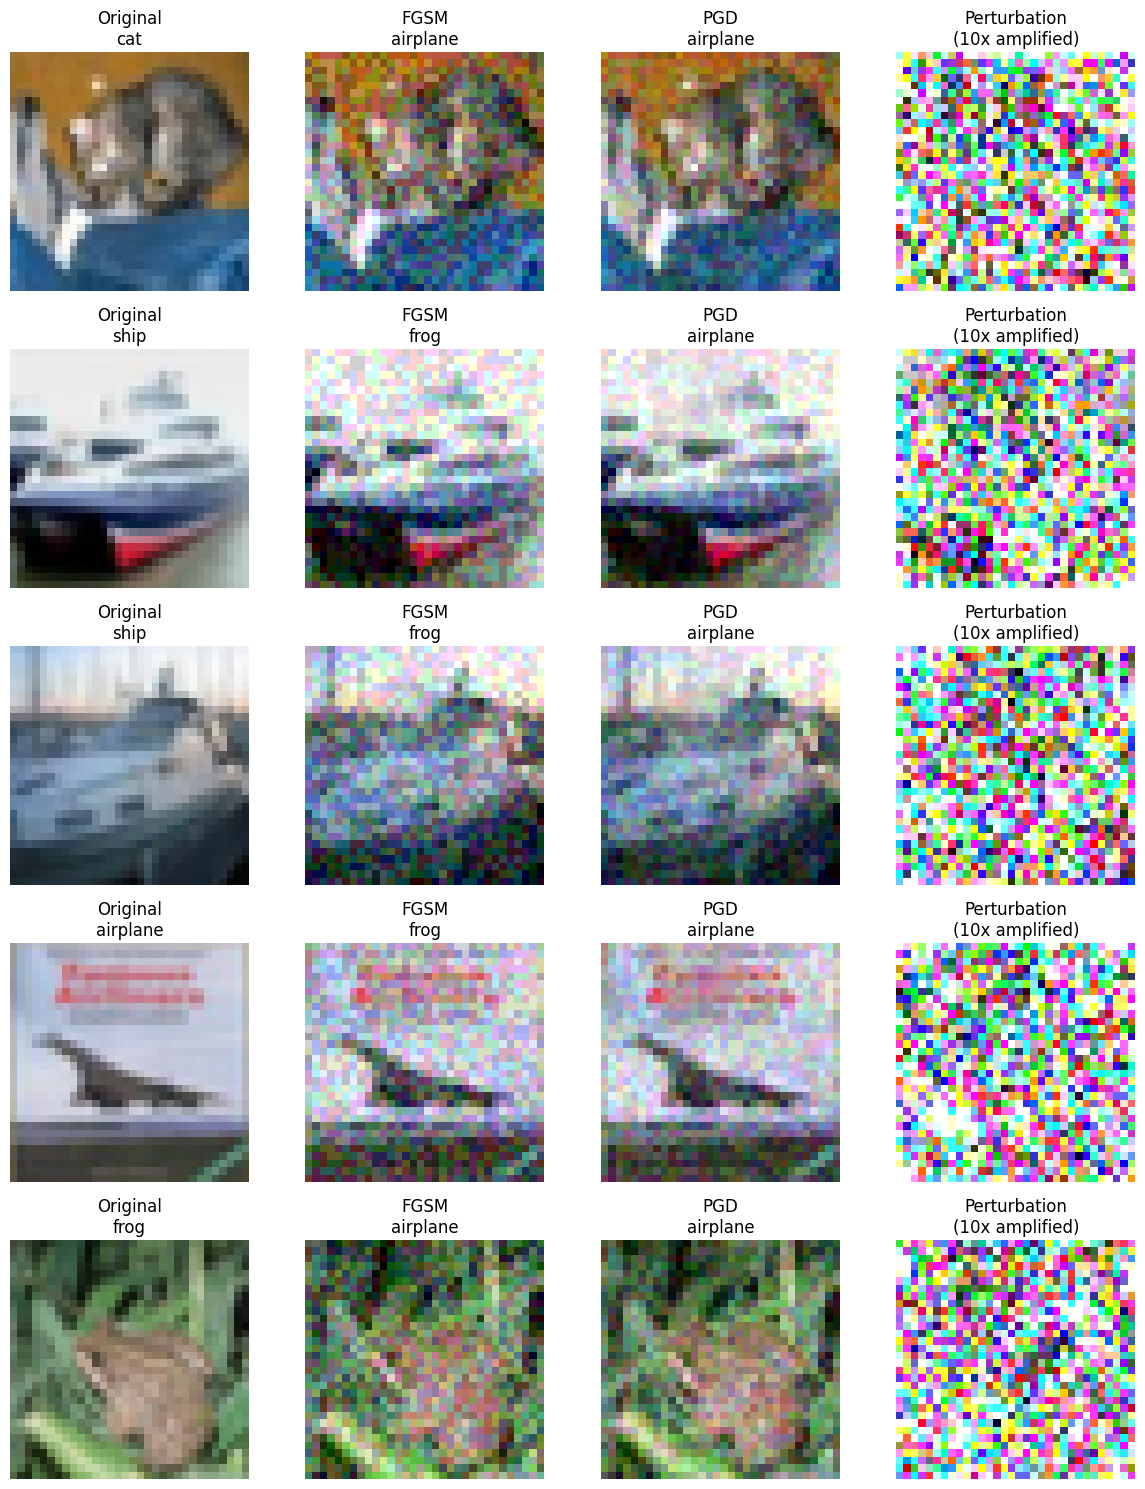

In [17]:
# Visualize original vs adversarial examples
def show_adversarial_examples(original, fgsm_adv, pgd_adv, labels, predictions, num_samples=5):
    fig, axes = plt.subplots(num_samples, 4, figsize=(12, 3*num_samples))
    
    for i in range(num_samples):
        # Original image
        axes[i, 0].imshow(np.transpose(original[i], (1, 2, 0)))
        axes[i, 0].set_title(f'Original\n{classes[labels[i]]}')
        axes[i, 0].axis('off')
        
        # FGSM adversarial
        axes[i, 1].imshow(np.transpose(fgsm_adv[i], (1, 2, 0)))
        pred_fgsm = np.argmax(classifier.predict(fgsm_adv[i:i+1]))
        axes[i, 1].set_title(f'FGSM\n{classes[pred_fgsm]}')
        axes[i, 1].axis('off')
        
        # PGD adversarial
        axes[i, 2].imshow(np.transpose(pgd_adv[i], (1, 2, 0)))
        pred_pgd = np.argmax(classifier.predict(pgd_adv[i:i+1]))
        axes[i, 2].set_title(f'PGD\n{classes[pred_pgd]}')
        axes[i, 2].axis('off')
        
        # Perturbation (amplified for visibility)
        perturbation = np.abs(pgd_adv[i] - original[i])
        axes[i, 3].imshow(np.transpose(perturbation * 10, (1, 2, 0)))
        axes[i, 3].set_title('Perturbation\n(10x amplified)')
        axes[i, 3].axis('off')
    
    plt.tight_layout()
    plt.show()

show_adversarial_examples(
    x_test,
    x_test_adv_fgsm,
    x_test_adv_pgd,
    y_test,
    predictions
)

## Part 6: Test Multiple Epsilon Values

Testing different epsilon values...

Epsilon: 0.01


PGD - Batches:   0%|          | 0/4 [00:00<?, ?it/s]

  FGSM accuracy: 16.00%
  PGD accuracy: 16.00%

Epsilon: 0.05


PGD - Batches:   0%|          | 0/4 [00:00<?, ?it/s]

  FGSM accuracy: 10.00%
  PGD accuracy: 9.00%

Epsilon: 0.1


PGD - Batches:   0%|          | 0/4 [00:00<?, ?it/s]

  FGSM accuracy: 6.00%
  PGD accuracy: 8.00%

Epsilon: 0.2


PGD - Batches:   0%|          | 0/4 [00:00<?, ?it/s]

  FGSM accuracy: 7.00%
  PGD accuracy: 10.00%

Epsilon: 0.3


PGD - Batches:   0%|          | 0/4 [00:00<?, ?it/s]

  FGSM accuracy: 6.00%
  PGD accuracy: 10.00%


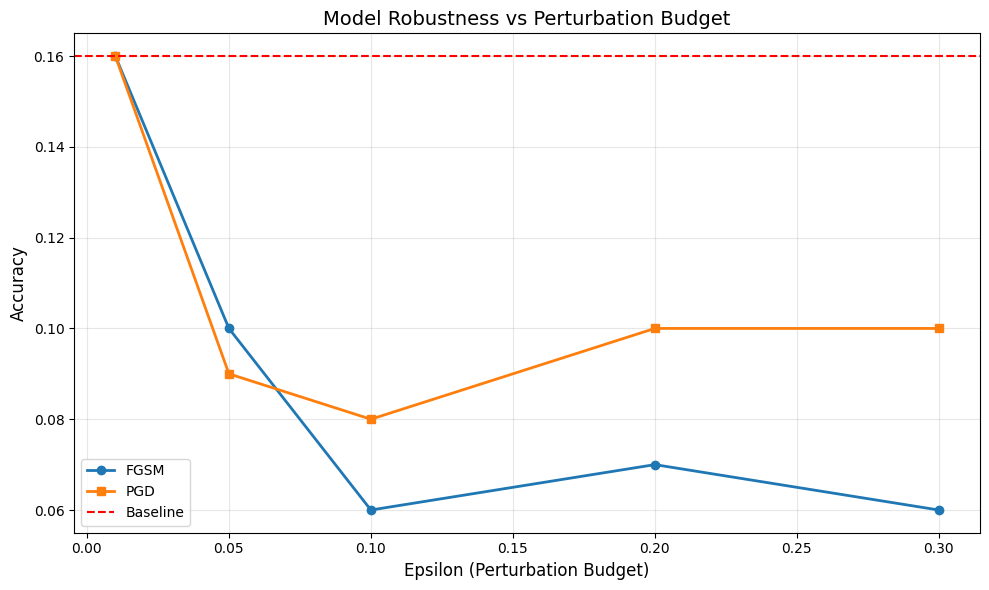

In [18]:
# Test different perturbation budgets
epsilon_values = [0.01, 0.05, 0.1, 0.2, 0.3]
results = {'epsilon': [], 'fgsm_accuracy': [], 'pgd_accuracy': []}

print('Testing different epsilon values...')
for eps in epsilon_values:
    print(f'\nEpsilon: {eps}')
    
    # FGSM
    fgsm_attack = FastGradientMethod(estimator=classifier, eps=eps)
    x_adv = fgsm_attack.generate(x=x_test)
    preds = classifier.predict(x_adv)
    fgsm_acc = np.sum(np.argmax(preds, axis=1) == y_test) / len(y_test)
    
    # PGD
    pgd_attack = ProjectedGradientDescent(
        estimator=classifier,
        eps=eps,
        eps_step=eps/10,
        max_iter=20
    )
    x_adv_pgd = pgd_attack.generate(x=x_test)
    preds_pgd = classifier.predict(x_adv_pgd)
    pgd_acc = np.sum(np.argmax(preds_pgd, axis=1) == y_test) / len(y_test)
    
    results['epsilon'].append(eps)
    results['fgsm_accuracy'].append(fgsm_acc)
    results['pgd_accuracy'].append(pgd_acc)
    
    print(f'  FGSM accuracy: {fgsm_acc:.2%}')
    print(f'  PGD accuracy: {pgd_acc:.2%}')

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(results['epsilon'], results['fgsm_accuracy'], 'o-', label='FGSM', linewidth=2)
plt.plot(results['epsilon'], results['pgd_accuracy'], 's-', label='PGD', linewidth=2)
plt.axhline(y=accuracy, color='r', linestyle='--', label='Baseline')
plt.xlabel('Epsilon (Perturbation Budget)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Model Robustness vs Perturbation Budget', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Part 7: Defense - JPEG Compression

In [19]:
# Apply JPEG compression as a defense (if available)
if JpegCompression is not None:
    jpeg_defense = JpegCompression(clip_values=(0, 1), quality=50)
    print('Applying JPEG compression defense...')
    x_test_adv_defended, _ = jpeg_defense(x_test_adv_pgd)
else:
    print('Note: JPEG compression defense not available in this ART version')
    print('Using simple clipping as alternative defense...')
    x_test_adv_defended = np.clip(x_test_adv_pgd, 0, 1)

# Evaluate defended examples
predictions_defended = classifier.predict(x_test_adv_defended)
accuracy_defended = np.sum(np.argmax(predictions_defended, axis=1) == y_test) / len(y_test)

print(f'\nDefense Results:')
print(f'  Baseline accuracy: {accuracy:.2%}')
print(f'  PGD adversarial accuracy: {accuracy_adv_pgd:.2%}')
print(f'  Defended accuracy: {accuracy_defended:.2%}')
print(f'  Defense improvement: {(accuracy_defended - accuracy_adv_pgd):.2%}')

Note: JPEG compression defense not available in this ART version
Using simple clipping as alternative defense...

Defense Results:
  Baseline accuracy: 16.00%
  PGD adversarial accuracy: 8.00%
  Defended accuracy: 8.00%
  Defense improvement: 0.00%


## Exercise: Comprehensive Robustness Evaluation

**Task**: Extend the evaluation to include:
1. Test C&W (Carlini-Wagner) attack
2. Compare attack success rates
3. Measure perturbation magnitudes
4. Generate a robustness report

**Hints**:
- Use `CarliniLInfMethod` from ART
- Calculate L2 and L-infinity norms
- Compare computational costs
- Document findings

In [20]:
# Your code here
# TODO: Implement C&W attack and comprehensive evaluation


## Summary

In this lab, you learned:
- ✅ How to set up and configure ART
- ✅ Implementing FGSM and PGD attacks
- ✅ Evaluating model robustness across different epsilon values
- ✅ Visualizing adversarial examples
- ✅ Applying basic defenses (clipping/compression)
- ✅ Measuring attack effectiveness

**Key Takeaways**:
1. PGD is generally stronger than FGSM
2. Larger epsilon values cause more accuracy degradation
3. Simple defenses can provide some protection
4. ART provides a unified interface for testing

**Next Steps**:
- Complete the exercise
- Try other attack methods (DeepFool, Boundary Attack)
- Experiment with adversarial training
- Proceed to Lab 2: TextAttack